# Statistical Methods for Drift Detection

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
housing_data = pd.read_csv('housing.csv')

### Kolmogorov-Smirnov Test
The KS Test compares the cumulative distributions of two datasets. It is a non-parametric test used to detect changes in the distribution of continuous variables.

In [3]:
from scipy.stats import ks_2samp

# Split the data into two subsets: first half and second half
split_index = len(housing_data) // 2
train_data = housing_data.iloc[:split_index]
test_data = housing_data.iloc[split_index:]

# Apply Kolmogorov-Smirnov test for continuous features
ks_results = {}
for column in housing_data.select_dtypes(include=['float64']).columns:
    ks_stat, p_value = ks_2samp(train_data[column], test_data[column])
    ks_results[column] = (ks_stat, p_value)

ks_results

{'longitude': (0.3223837209302326, 0.0),
 'latitude': (0.24234496124031005, 2.9215202857566935e-267),
 'housing_median_age': (0.24525193798449613, 8.628087865866243e-274),
 'total_rooms': (0.121608527131783, 5.8548270019556876e-67),
 'total_bedrooms': (0.07684108527131783, 6.044007261138568e-27),
 'population': (0.047383720930232576, 1.6589285958154983e-10),
 'households': (0.07936046511627903, 1.0282228152403217e-28),
 'median_income': (0.0832364341085271, 1.507081784975793e-31),
 'median_house_value': (0.04118217054263573, 4.845684412012565e-08)}

### Analysis
The test calculates the maximum distance between the cumulative distributions of the two samples.

**What does it mean?**
- **KS Statistic**: Measures the maximum difference between the empirical distribution functions of the two samples.
- **p-value**: Indicates the probability of observing the data if the null hypothesis is true. A low p-value (typically < 0.05) suggests that the two distributions are different.

**Result:**
- If the KS statistic is large and the p-value is low, there is significant drift in the feature distribution between the two subsets.
- If the p-value is high, there is no significant evidence of drift.

**Example:**

    KS Statistic: 0.242
    P-value: 2.92e-267

The KS statistic indicates the maximum difference between the cumulative distributions of <code>**latitude**</code> in the two periods. The very small p-value suggests that there is a statistically significant difference between the distributions, indicating potential drift.

### Chi-Square Test
The Chi-Square Test compares the distribution of categorical variables. It assesses whether the observed frequency distribution of a categorical variable differs from an expected distribution.

In [4]:
# Separate features and target variable
X = housing_data.drop('median_house_value', axis=1)
y = housing_data['median_house_value']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### First, we count the number of repetitions of each categorical feature, in this case <code>ocean_proximity</code> in both parts of the dataset.

In [5]:
from scipy.stats import chi2_contingency

# Perform Chi-Squared test for the categorical feature
cat_feature = 'ocean_proximity'

# Ensure both sets have the same categories for 'ocean_proximity'
train_categories = X_train[cat_feature].value_counts().index
test_categories = X_test[cat_feature].value_counts().index
all_categories = train_categories.union(test_categories)

# Reindex to ensure the contingency table includes all categories
train_ocean_proximity = X_train[cat_feature].value_counts().reindex(all_categories, fill_value=0)
test_ocean_proximity = X_test[cat_feature].value_counts().reindex(all_categories, fill_value=0)

# Create contingency table
contingency_table = pd.DataFrame({
    'train': train_ocean_proximity,
    'test': test_ocean_proximity
})

contingency_table

,train,test
ocean_proximity,,
<1H OCEAN,7341,1795
INLAND,5227,1324
NEAR OCEAN,2086,572
NEAR BAY,1854,436
ISLAND,4,1


In [6]:
# Perform Chi-Squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

chi2_stat, p_value

(6.049807848802171, 0.19545934336143966)

### Analysis
- **Chi-squared Statistic**: Measures how the observed count differs from the expected count.
- **p-value**: Indicates the probability that the observed differences are due to chance. A low p-value (typically < 0.05) suggests a significant difference.

**Result**:

    Chi-Squared Statistic: 6.04
    P-value: 0.195

If the p-value is high (typically >0.05), there is no significant evidence of drift.

### Jensen-Shannon Divergence (JSD)
JSD measures the similarity between two probability distributions. It is based on the Kullback-Leibler divergence and is useful for comparing distributions in a symmetrical and bounded manner.

In [7]:
from scipy.spatial.distance import jensenshannon

# Function to compute JSD
def compute_jsd(p, q):
    p_norm = p / np.sum(p)
    q_norm = q / np.sum(q)
    return jensenshannon(p_norm, q_norm)**2

# Compute histograms for 'median_house_value' in each period
hist_period_1, bin_edges = np.histogram(train_data['median_house_value'], bins=30, density=True)
hist_period_2, _ = np.histogram(test_data['median_house_value'], bins=bin_edges, density=True)

# Compute JSD
jsd_value = compute_jsd(hist_period_1, hist_period_2)
jsd_value


0.003870892375691833

### Analysis
The JSD value is relatively small, indicating that the probability distributions of <code>**median_house_value**</code> between the two periods are quite similar (no drift). However, this doesn't necessarily contradict the KS test result, as JSD and KS test measure different aspects of the distributions.

**Interpreting JSD Values**:

    0 to 0.1: The distributions are very similar.
    0.1 to 0.5: The distributions are moderately different.
    0.5 to 1.0: The distributions are very different.

### Population Stability Index (PSI)
PSI measures the shift in the distribution of a variable between two periods. It is widely used in the financial industry to monitor changes in the population of borrowers.

In [8]:
# Function to compute PSI
def compute_psi(expected, actual, buckets=10):
    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    breakpoints = np.arange(0, buckets + 1) / buckets * 100
    breakpoints = np.percentile(expected, breakpoints)
    
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    
    psi_value = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
    return psi_value

# Compute PSI for 'median_house_value'
psi_value = compute_psi(train_data['median_house_value'], test_data['median_house_value'])
psi_value


0.02197533996887932

### Analysis
he PSI value indicates the magnitude of shift between the distributions of <code>median_house_value</code> in the two periods.


**What does it mean?**

    less than 0.1: No significant change
    0.1 - 0.2: Slight change
    greather than 0.2: Major change

With a PSI value of approximately 0.022, it suggests that there is no significant change in the distribution of <code>**median_house_value**</code> between the two periods.

### Visualization
Visualizing the data distributions helps to intuitively understand the differences.
- Histograms and density plots show the distribution of continuous features.
- Count plots show the distribution of categorical features.

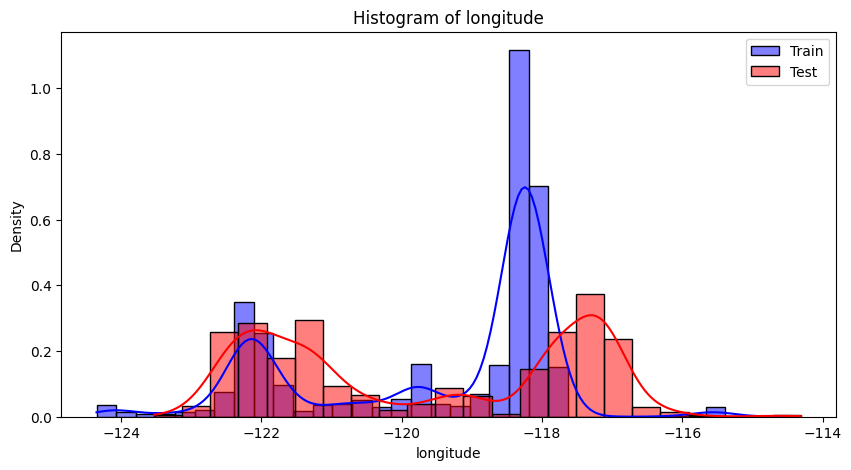

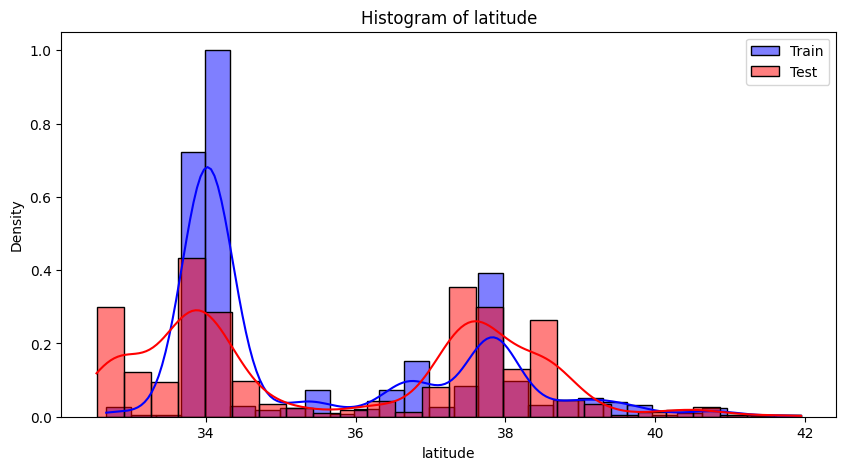

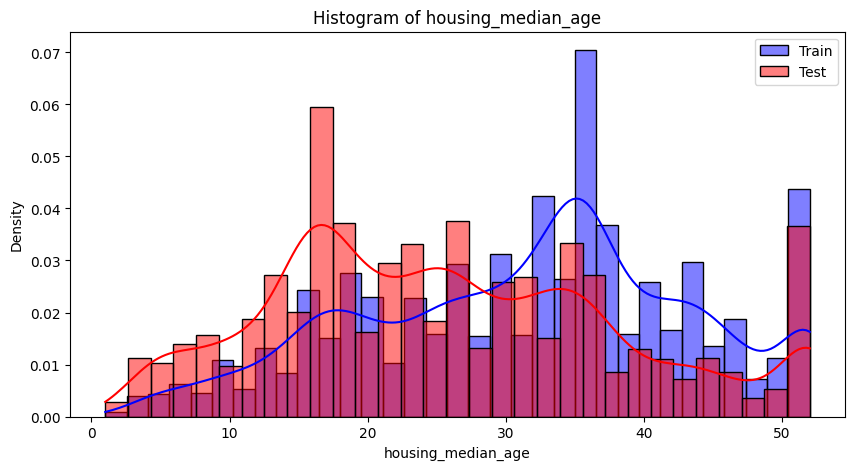

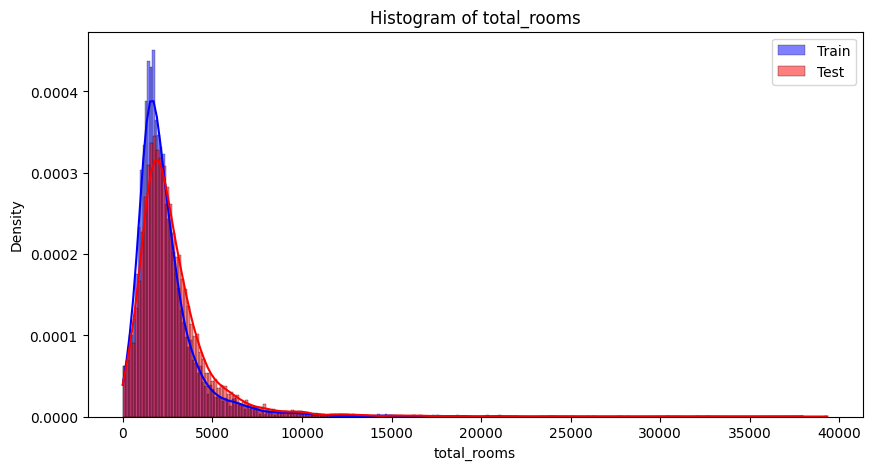

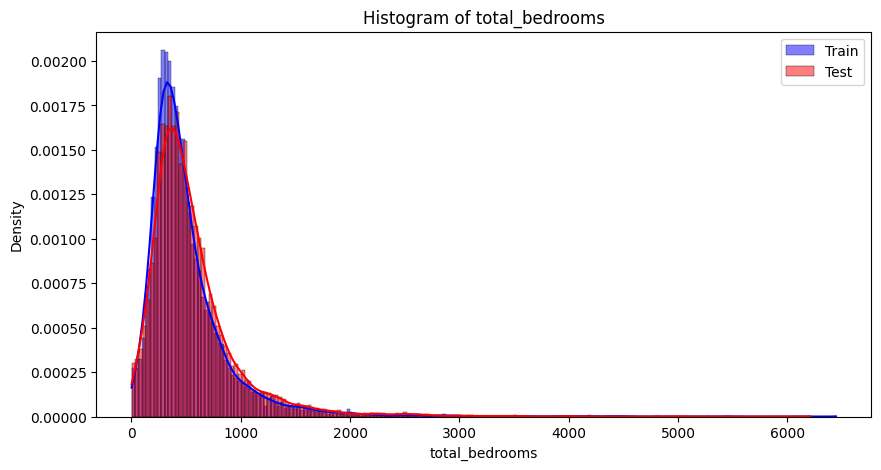

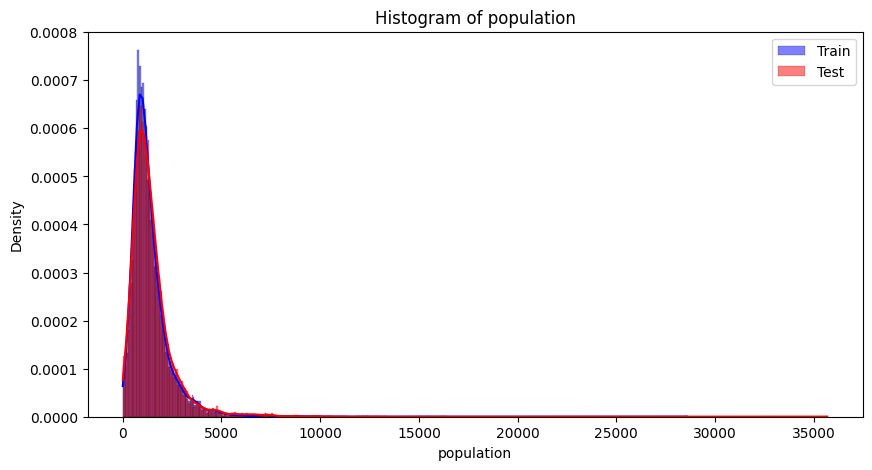

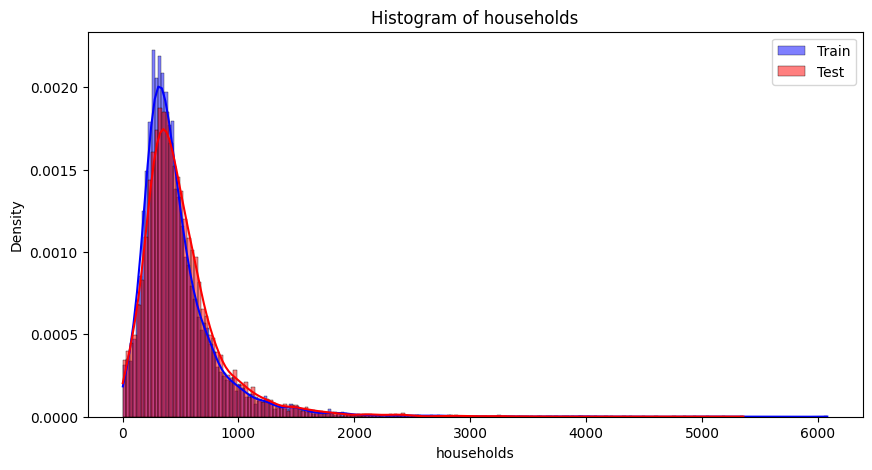

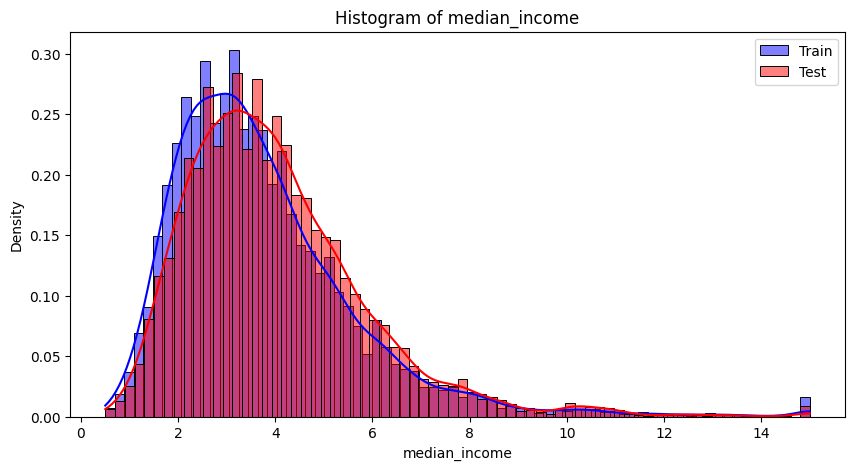

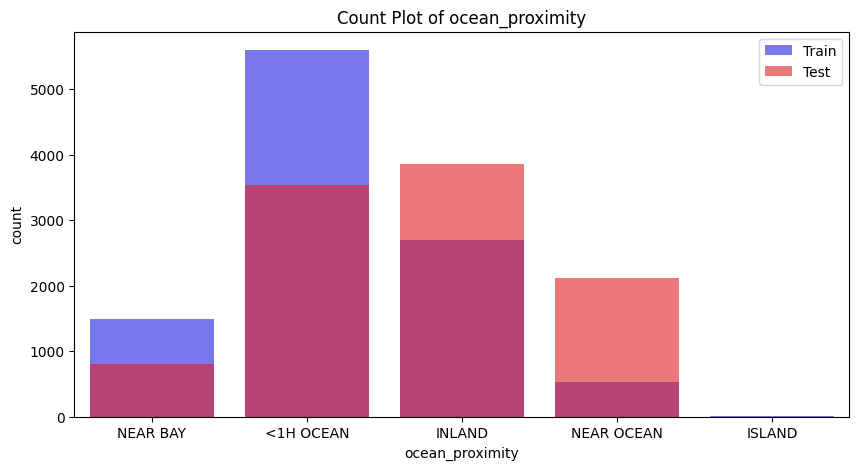

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for continuous features
for column in X.select_dtypes(include=['float64']).columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(train_data[column], color='blue', label='Train', kde=True, stat="density")
    sns.histplot(test_data[column], color='red', label='Test', kde=True, stat="density")
    plt.title(f'Histogram of {column}')
    plt.legend()
    plt.show()

# Plot count plots for categorical features
for column in X.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=train_data, x=column, color='blue', label='Train', alpha=0.6)
    sns.countplot(data=test_data, x=column, color='red', label='Test', alpha=0.6)
    plt.title(f'Count Plot of {column}')
    plt.legend()
    plt.show()


### Analysis

By comparing the plots for the train and test subsets, we can visually inspect for differences in distributions.
- Significant differences in the shapes of the distributions indicate drift.
- Overlapping distributions suggest no significant drift.